<a href="https://colab.research.google.com/github/Pataweepr/applyML_vistec_2019/blob/master/TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Virus Classification using Support Vector Machines (SVM)

In this lab we will classify viruses into their sub families using their DNA sequence. This has potential applications in disease control where scientists can monitor the spread and mutations of viruses, and potentially try to identify whether when a benign virus will mutate to a malignant virus.

For this lab we will mainly use Support Vector Machines ([SVM](https://scikit-learn.org/stable/modules/svm.html))

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import collections
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from IPython.display import display
from scipy.stats import mode

from sklearn.svm import SVC

seed = 976
np.random.seed(seed)

import time

## The data

The data can be found [here](https://drive.google.com/file/d/1tb1pvtUNqx3r4FVbNsRKum2hwaLOIYmO/view?usp=sharing). Click add to drive so that you can mount it later.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
df = pd.read_csv("/content/gdrive/My Drive/Chosen_Data_clearToN.csv")

In [0]:
## TODO#1 ##
df = df[["Sequences", "Label"]]
key_virus = df["Label"].value_counts().index
print(key_virus)

Each DNA string has different length. Plot the histogram of the length of the DNA.

In [0]:
## TODO#2 ##
df["len"] = df["Sequences"].apply(len)
len_np = df["len"].values
n, bins, patches = plt.hist(len_np, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

In [0]:
def splitTrainTest(data):
  keyDatas = data["Label"].value_counts().keys()
  train = pd.DataFrame()
  valid = pd.DataFrame()
  test = pd.DataFrame()
  chk = 0
  for k in keyDatas:
    tmp = data[data["Label"]==k]
    tmp_train, tmp_test = train_test_split(tmp, test_size=2/5, random_state=seed)
    tmp_train, tmp_valid = train_test_split(tmp_train, test_size=1/6, random_state=seed)
    train = train.append(tmp_train)
    valid = valid.append(tmp_valid)
    test = test.append(tmp_test)
  return train, valid, test

In [0]:
df_train, df_valid, df_test = splitTrainTest(df)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [0]:
## TODO#3 ##
df_train["Label"].value_counts()

In [0]:
def createGram(sequence, gram=5):
  # sequence is the DNA sequence
  # returns: np array where each entry is an n-gram count

  ## TODO#4 ##
  nGram = dict.fromkeys(["".join(x) for x in itertools.product("ACTG",repeat=gram) ],0)
  for i in  range(len(sequence)-gram+1):
    if "N" not in str([sequence[i:i+gram]]):
      nGram[sequence[i:i+gram]]+=1
  return np.array(list(nGram.values()))

In [0]:
# Try
print(createGram('AGTCATC',1))
print(createGram('AGTCATC',2))

#You should get
#[2 2 2 1]
#[0 0 1 1 1 0 0 0 0 2 0 0 0 0 1 0]

In [0]:
def createGramDataset(data, gram=5, length=10000, train=False):
  datangram = []
  label = []

  if(train):
    # Upsampling if training data
    
    # Assume first class has maximum amount
    max_sam = data["Label"].value_counts()[0]
    # For each label
    for i in data["Label"].value_counts().keys():
      tmp_virus = data[data["Label"]==i]
      tmp_virus = tmp_virus.reset_index(drop=True)
      # Upsample by j times
      for j in range(0, max_sam//len(tmp_virus)):
        # For data point
        for k in range(len(tmp_virus)):
          # Select location of the sub-sequence
          if(len(tmp_virus["Sequences"][k])-length == 0):
            rand_int = 0
          else:
            rand_int = np.random.randint(len(tmp_virus["Sequences"][k])-length)
          selected_sequence = tmp_virus["Sequences"][k][rand_int:rand_int+length]
          datangram.append(createGram(tmp_virus["Sequences"][k]))
          label.append(i)
  else:
    # For data point
    for k in range(len(data)):
      if (len(data["Sequences"][k])-length == 0) :
        rand_int = 0
      else:
        rand_int = np.random.randint(len(data["Sequences"][k])-length)
      selected_sequence = data["Sequences"][k][rand_int:rand_int+length]
      datangram.append(createGram(data["Sequences"][k]))
      label.append(data["Label"][k])

  return np.array(datangram), label

In [0]:
X_train, y_train = createGramDataset(df_train, 5, 20000, True)
X_valid, y_valid = createGramDataset(df_valid, 5, 20000, False)
X_test, y_test = createGramDataset(df_test, 5, 20000, False)

buildlLabel() is a function that maps categorical values to numbers.

In [0]:
def buildLabel(y_str_label,key_virus_label):
  nplabel = []
  for lab in y_str_label:
    for i in np.arange(len(key_virus_label)):
      if(lab == key_virus_label[i]):
        nplabel.append(i+1)
        break
  return np.array(nplabel)

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def eval(y_pred,y_test):
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='macro') 
  prec = precision_score(y_test, y_pred, average='macro') 
  recall = recall_score(y_test, y_pred, average='macro') 
  return acc, f1, prec, recall

In [0]:
y_train = buildLabel(y_train,key_virus)
y_valid = buildLabel(y_valid,key_virus)
y_test = buildLabel(y_test,key_virus)
print(y_train)

In [0]:
# Shuffle the training data so that classes will not appear together.
X_train, y_train = shuffle(X_train, y_train, random_state=seed)

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,n_iter=10000,random_state = seed).fit_transform(X_train)
colors = ['r','g','b','c','y','k']
for i in range(1,7):
  label_i = (y_train == i) 
  plt.scatter(X_embedded[label_i,0],X_embedded[label_i,1],c = colors[i-1])
plt.show()

In [0]:
X_embedded_2 = TSNE(n_components=3,n_iter=15000,random_state = seed).fit_transform(X_train)
from mpl_toolkits.mplot3d import Axes3D
colors = ['r','g','b','c','y','k']

In [0]:
# 300 120

ii = 120
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

print('print ', ii)

ax.view_init(elev=10., azim=ii)
for i in range(1,7):
  label_i = (y_train == i) 
  ax.scatter(X_embedded_2[label_i,0],X_embedded_2[label_i,1],X_embedded_2[label_i,2],c = colors[i-1])
plt.show()
print('-----------------------------------------------------------------------------------------------')

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

y_test_new = np.zeros(len(y_test),dtype ='int') 
y_train_new = np.zeros(len(y_train),dtype ='int')
y_valid_new = np.zeros(len(y_valid),dtype ='int')

y_test_new[y_test == 3] = 1
y_train_new[y_train == 3] = 1
y_valid_new[y_valid == 3] = 1


############ linear
clf_Linear = SVC(kernel='linear',probability=True)
clf_Linear.fit(X_train, y_train)
y_pred_linear = clf_Linear.predict(X_test)
y_test_lin_score = clf_Linear.predict_proba(X_test)[:,1]

acc, f1, precision, recall = eval(y_pred_linear,y_test)
fpr_linear, tpr_linear, thresholds_linear = roc_curve(y_test_new,y_test_lin_score)

print('Linear_kernel')
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

############ poly
clf_poly = SVC(kernel='poly',degree = 2,gamma='auto',probability=True)
clf_poly.fit(X_train, y_train)
y_pred_poly = clf_poly.predict(X_test)
y_test_poly_score = clf_poly.predict_proba(X_test)[:,1]

acc, f1, precision, recall = eval(y_pred_poly,y_test)
fpr_poly, tpr_poly, thresholds_poly = roc_curve(y_test_new,y_test_poly_score)

print('poly_kernel')
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

############ rbf

clf_rbf = SVC(kernel='rbf',gamma = 10**-5,probability=True)
clf_rbf.fit(X_train, y_train_new)
y_pred_rbf = clf_rbf.predict(X_test)
y_test_rbf_score = clf_rbf.predict_proba(X_test)[:,1]

acc, f1, precision, recall = eval(y_pred_rbf,y_test_new)
fpr_rbf, tpr_rbf, thresholds_rbf = roc_curve(y_test_new,y_test_rbf_score)

print('rbf_kernel')
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

############ 

plt.plot(fpr_linear,tpr_linear,label="linear")
plt.plot(fpr_poly,tpr_poly,label="poly")
plt.plot(fpr_rbf,tpr_rbf,label="rbf")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.show()

[link confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [0]:
## TODO#7 ##
key_virus_new = ['others','hku']
y_test_new = np.zeros(len(y_test),dtype ='int') 
y_train_new = np.zeros(len(y_train),dtype ='int')
y_valid_new = np.zeros(len(y_valid),dtype ='int')

y_test_new[y_test == 3] = 1
y_train_new[y_train == 3] = 1
y_valid_new[y_valid == 3] = 1

clf_rbf_new = SVC(kernel='rbf',gamma = 10**val,probability=True)
clf_rbf_new.fit(X_train, y_train_new)

print(clf_rbf_new.n_support_ )


y_pred_rbf = clf_rbf_new.predict(X_test)
n, bins, patches = plt.hist(y_pred_rbf, 50, density=True, facecolor='g', alpha=0.75)
plt.show()
y_test_rbf_score = clf_rbf_new.predict_proba(X_test)[:,1]
acc_test, f1, precision, recall = eval(y_pred_rbf,y_test_new)
confuse_test_2 = confusion_matrix(y_test_new, y_pred_rbf)
confuse_test_2 = confuse_test/confuse_test.sum(axis = 1)
print(confuse_test_2.shape)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_new,y_test_rbf_score)

y_pred_rbf = clf_rbf_new.predict(X_valid)
y_valid_rbf_score = clf_rbf_new.predict_proba(X_valid)[:,1]
acc_val, f1, precision, recall = eval(y_pred_rbf,y_valid_new)
confuse_val_2 = confusion_matrix(y_valid_new, y_pred_rbf)
confuse_val_2 = confuse_val/confuse_val.sum(axis = 1)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid_new,y_valid_rbf_score)

y_pred_rbf = clf_rbf_new.predict(X_train)
y_train_rbf_score = clf_rbf_new.predict_proba(X_train)[:,1]
acc_train, f1, precision, recall = eval(y_pred_rbf,y_train_new)
confuse_train_2 = confusion_matrix(y_train_new, y_pred_rbf)
confuse_train_2 = confuse_train/confuse_train.sum(axis = 1)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_new,y_train_rbf_score)

print('###################################################')
print('train')
df_train = pd.DataFrame(data=confuse_train_2 )
ax = sns.heatmap(df_train, annot=True, fmt="g")
plt.show()

print('###################################################')
print('valid')
df_valid = pd.DataFrame(data=confuse_val_2 )
ax = sns.heatmap(df_valid , annot=True, fmt="g")
plt.show()

print('###################################################')
print('test')
df_test = pd.DataFrame(data=confuse_test_2)
ax = sns.heatmap(df_test, annot=True, fmt="g")
plt.show()

print('###################################################')
'''
plt.plot(fpr_train,tpr_train,label="train")
plt.plot(fpr_valid,tpr_valid,label="valid")
plt.plot(fpr_test,tpr_test,label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.show()
'''



In [0]:
## TODO#7 ##

val = -5

clf_rbf_all = SVC(kernel='rbf',gamma = 10**val,probability=True)
clf_rbf_all.fit(X_train, y_train)
y_pred_rbf = clf_rbf_all.predict(X_test)
y_test_rbf_score = clf_rbf_all.predict_proba(X_test)[:,1]
acc_test, f1, precision, recall = eval(y_pred_rbf,y_test)
confuse_test = confusion_matrix(y_test, y_pred_rbf)
confuse_test = confuse_test/confuse_test.sum(axis = 1)

y_pred_rbf = clf_rbf_all.predict(X_valid)
y_valid_rbf_score = clf_rbf_all.predict_proba(X_valid)[:,1]
acc_val, f1, precision, recall = eval(y_pred_rbf,y_valid)
confuse_val = confusion_matrix(y_valid, y_pred_rbf)
confuse_val = confuse_val/confuse_val.sum(axis = 1)

y_pred_rbf = clf_rbf_all.predict(X_train)
y_train_rbf_score = clf_rbf_all.predict_proba(X_train)[:,1]
acc_train, f1, precision, recall = eval(y_pred_rbf,y_train)
confuse_train = confusion_matrix(y_train, y_pred_rbf)
confuse_train = confuse_train/confuse_train.sum(axis = 1)

print('###################################################')
print('train')
df_train_2 = pd.DataFrame(data=confuse_train, index=key_virus, columns = key_virus)
ax = sns.heatmap(df_train_2, annot=True, fmt="g")
plt.show()

print('###################################################')
print('valid')
df_valid_2 = pd.DataFrame(data=confuse_val, index=key_virus, columns = key_virus)
ax = sns.heatmap(df_valid_2 , annot=True, fmt="g")
plt.show()

print('###################################################')
print('test')
df_test_2 = pd.DataFrame(data=confuse_test, index=key_virus, columns = key_virus)
ax = sns.heatmap(df_test_2, annot=True, fmt="g")
plt.show()



In [0]:
## TODO#8 ##

In [0]:
df_cut = df.copy()
sub_Sequences = [x[8000:10001] for x in df_cut['Sequences'].values]
df_cut['sub_Sequences'] = sub_Sequences
df_cut = df_cut[['sub_Sequences','Label']]

df_cut.rename(columns={'sub_Sequences': 'Sequences'}, inplace=True)

df_cut_train, df_cut_valid, df_cut_test = splitTrainTest(df_cut)
df_cut_train = df_cut_train.reset_index(drop=True)
df_cut_valid = df_cut_valid.reset_index(drop=True)
df_cut_test = df_cut_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createGramDataset(df_cut_train, 5, 2000, True)
X_valid_key_seq, y_valid_key_seq = createGramDataset(df_cut_valid, 5, 2000, False)
X_test_key_seq, y_test_key_seq = createGramDataset(df_cut_test, 5, 2000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)


In [0]:
a = range(-7,0)
acc_train = np.zeros((7,))
acc_val = np.zeros((7,))
acc_test = np.zeros((7,))
for idx, val in enumerate(a):
  clf_rbf = SVC(kernel='rbf',gamma = 10**val,probability=True)
  clf_rbf.fit(X_train_key_seq, y_train_key_seq)
  y_pred_rbf = clf_rbf.predict(X_test_key_seq)
  acc_test[idx], f1, precision, recall = eval(y_pred_rbf,y_test_key_seq)
  y_pred_rbf = clf_rbf.predict(X_valid_key_seq)
  acc_val[idx], f1, precision, recall = eval(y_pred_rbf,y_valid_key_seq)
  y_pred_rbf = clf_rbf.predict(X_train_key_seq)
  acc_train[idx], f1, precision, recall = eval(y_pred_rbf,y_train_key_seq)
  
  
  

In [80]:
df_cut = df.copy()
sub_Sequences = [x[6000:8001] for x in df_cut['Sequences'].values]
df_cut['sub_Sequences'] = sub_Sequences
df_cut = df_cut[['sub_Sequences','Label']]

df_cut.rename(columns={'sub_Sequences': 'Sequences'}, inplace=True)

df_cut_train, df_cut_valid, df_cut_test = splitTrainTest(df_cut)
df_cut_train = df_cut_train.reset_index(drop=True)
df_cut_valid = df_cut_valid.reset_index(drop=True)
df_cut_test = df_cut_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createGramDataset(df_cut_train, 5, 2000, True)
X_valid_key_seq, y_valid_key_seq = createGramDataset(df_cut_valid, 5, 2000, False)
X_test_key_seq, y_test_key_seq = createGramDataset(df_cut_test, 5, 2000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)

clf = SVC(kernel ='linear')
clf.fit(X_train_key_seq, y_train_key_seq)
y_pred = clf.predict(X_test_key_seq)

acc, f1, precision, recall = eval(y_pred,y_test_key_seq)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

accuracy : 0.948936170212766
f1 : 0.9473153009633499
precision : 0.9611558515518569
recall : 0.935782232473409


In [81]:
a = range(-7,0)
acc_train = np.zeros((7,))
acc_val = np.zeros((7,))
acc_test = np.zeros((7,))
for idx, val in enumerate(a):
  clf_rbf = SVC(kernel='rbf',gamma = 10**val)
  clf_rbf.fit(X_train_key_seq, y_train_key_seq)
  y_pred_rbf = clf_rbf.predict(X_test_key_seq)
  acc_test[idx], f1, precision, recall = eval(y_pred_rbf,y_test_key_seq)
  y_pred_rbf = clf_rbf.predict(X_valid_key_seq)
  acc_val[idx], f1, precision, recall = eval(y_pred_rbf,y_valid_key_seq)
  y_pred_rbf = clf_rbf.predict(X_train_key_seq)
  acc_train[idx], f1, precision, recall = eval(y_pred_rbf,y_train_key_seq)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py

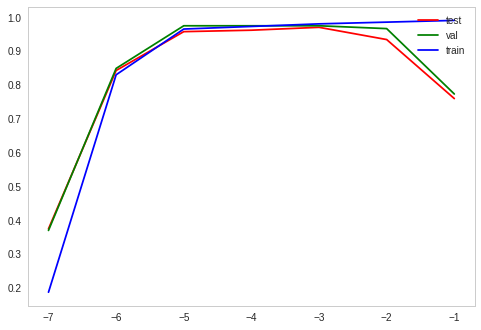

0.9702127659574468


In [82]:
plt.plot(a,acc_test,'r')
plt.plot(a,acc_val,'g')
plt.plot(a,acc_train,'b')
plt.legend(('test', 'val', 'train'),loc='upper right')
plt.show()

print(np.max(acc_test))

In [0]:
## TODO#9 ##
df_train, df_valid, df_test = splitTrainTest(df)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createGramDataset(df_train, 5, 20000, True)
X_valid_key_seq, y_valid_key_seq = createGramDataset(df_valid, 5, 20000, False)
X_test_key_seq, y_test_key_seq = createGramDataset(df_test, 5, 20000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)

In [0]:
train_acc = [] 
test_acc = []
number_sv = []
runtime = []

a = range(-4,4)

for idx,val in enumerate(a):
  clf = SVC(gamma='auto',C=10**val,probability=True)
  start_time = time.time()
  for runs in range(10):
    clf.fit(X_train_key_seq, y_train_key_seq)
  end_time = time.time()
  y_pred_train = clf.predict(X_train_key_seq)
  y_pred = clf.predict(X_test_key_seq)

In [0]:
plt.plot(a, np.array(train_acc), 'r', a, np.array(test_acc), 'b')
plt.legend(('train', 'test'),loc='upper right')
plt.show()

plt.plot(a, np.array(number_sv), 'r')
plt.show()

plt.plot(a, np.array(runtime), 'r')
plt.show()

<details>
    <summary>SOLUTION HERE!</summary>
      <pre>
        <code>
df_train, df_valid, df_test = splitTrainTest(df)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createGramDataset(df_train, 5, 20000, True)
X_valid_key_seq, y_valid_key_seq = createGramDataset(df_valid, 5, 20000, False)
X_test_key_seq, y_test_key_seq = createGramDataset(df_test, 5, 20000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)

train_acc = [] 
test_acc = []
number_sv = []
runtime = []

a = range(-4,4)

for idx,val in enumerate(a):
  clf = SVC(gamma='auto',C=10**val)
  start_time = time.time()
  for runs in range(10):
    clf.fit(X_train_key_seq, y_train_key_seq)
  end_time = time.time()
  y_pred_train = clf.predict(X_train_key_seq)
  y_pred = clf.predict(X_test_key_seq)
  
  number_sv.append(np.sum(clf.n_support_))
  acc_train, _, _, _ = evluate(y_pred_train,y_train_key_seq)
  acc_test, _, _, _ = evluate(y_pred,y_test_key_seq)
  train_acc.append(acc_train)
  test_acc.append(acc_test)
  runtime.append((end_time - start_time)/10)
  
plt.plot(a, np.array(train_acc), 'r', a, np.array(test_acc), 'b')
plt.legend(('train', 'test'),loc='upper right')
plt.show()

plt.plot(a, np.array(number_sv), 'r')
plt.show()

plt.plot(a, np.array(runtime), 'r')
plt.show()
        </code>
      </pre>
</details>